In [1]:
import math
import random
import numpy
from collections import *

In [2]:
class HMM:
    """
    Simple class to represent a Hidden Markov Model.
    """
    def __init__(self, order, initial_distribution, emission_matrix, transition_matrix):
        self.order = order
        self.initial_distribution = initial_distribution
        self.emission_matrix = emission_matrix
        self.transition_matrix = transition_matrix

In [3]:
def read_pos_file(filename):
    """
    Parses an input tagged text file.
    Input:
    filename --- the file to parse
    Returns: 
    The file represented as a list of tuples, where each tuple 
    is of the form (word, POS-tag).
    A list of unique words found in the file.
    A list of unique POS tags found in the file.
    """
    file_representation = []
    unique_words = set()
    unique_tags = set()
    f = open(str(filename), "r")
    for line in f:
        if len(line) < 2 or len(line.split("/")) != 2:
            continue
        
        word = line.split("/")[0].replace(" ", "").replace("\t", "").strip()
        tag = line.split("/")[1].replace(" ", "").replace("\t", "").strip()
        file_representation.append( (word, tag) )
        unique_words.add(word)
        unique_tags.add(tag)
    
    f.close()
    
    return file_representation, unique_words, unique_tags



In [4]:
def read_pos_file_modified(training_data_file):
    """
    A modified verysion of read_pos that only returns the file representation
    Input: training data file, a text file
    Output: The file represented as a list of tuples, where each tuple 
    is of the form (word, POS-tag).
    """
    file_representation = []

    #open file
    f = open(str(training_data_file), "r")
    for line in f:
        if len(line) < 2 or len(line.split("/")) != 2:
            continue

        #split the string up
        word = line.split("/")[0].replace(" ", "").replace("\t", "").strip()
        tag = line.split("/")[1].replace(" ", "").replace("\t", "").strip()
        file_representation.append( (word, tag) )

    # close the file
    f.close()
    return file_representation

In [5]:
################################### Testing RPOSFM 
print (read_pos_file_modified("onesentence.txt"))
#expects The file represented as a list of tuples, where each tuple is of the form (word, POS-tag).
#passes

[('The', 'DT'), ('New', 'NNP'), ('Deal', 'NNP'), ('was', 'VBD'), ('a', 'DT'), ('series', 'NN'), ('of', 'IN'), ('domestic', 'JJ'), ('programs', 'NNS'), ('enacted', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('United', 'NNP'), ('States', 'NNPS'), ('between', 'IN'), ('1933', 'CD'), ('and', 'CC'), ('1936', 'CD'), (',', ','), ('and', 'CC'), ('a', 'DT'), ('few', 'JJ'), ('that', 'WDT'), ('came', 'VBD'), ('later', 'RB'), ('.', '.')]


In [6]:
def parse_test_file(test_file):
    """
    Parses a test file into a list of lists, where the inner lists are sentences
    Input: A testing data file, test_file
    Outputs: a list of words in the file, and a list of lists as described above
    """

    # open the file
    f = open(test_file, "r")

    #split the file into a list
    list_of_words = f.read().split()
    testing_block = []
    L = len(list_of_words)
    count = 0

    while count < L:

        #container for each sentence
        sentence = []
        for word in list_of_words:

            #add word to the sentence
            sentence.append(word)
            count += 1
            if word == ".":

                # add sentence to the testing block
                testing_block.append(sentence)
                sentence = []

    return list_of_words, testing_block


In [7]:
############################## TESTING PARSE  ####################################
# print (parse_test_file("testdata_untagged.txt"))
#expect the test data parsed into a list of list
#passes


In [8]:
def wrangle_data(training_data_file, percent):
    """
    Inputs: training_data_file, a text file of tagged training data 
            percent: a decimal represeting the amount of data you want to build a model on 
    Output: partitioned data, a sequence of (word, tag) tuples
    """
    #read in data
    data = read_pos_file_modified(training_data_file)

    #get the total length of the training data
    tokens = len(data)

    #get the amount of tokens you want to keep 
    end_token = int(tokens*percent)

    partitioned_data = []

    #iterate until you read the end number of tokens
    for i in range(end_token):
        partitioned_data.append(data[i])

    return partitioned_data

In [9]:

############################################# TESTING Wrangle Data #############################################
#print (wrangle_data("training.txt", 0.01))[1]
# expects 1 percent of the training data
# passes

In [10]:
def get_unique_words_and_tags(data):
    """
    Gets the unique words and tags in a data set
    Input: Data in the representation returned by read pos
    Output: 2 sets, one that holds the unique words and one that holds the unique tags
    """

    #init empty sets
    unique_words = set([])
    unique_tags = set([])


    for pair in data:

        #add the word if its not already been seen
        if pair[0] not in unique_words:
            unique_words.add(pair[0])

        #add the tag if its not already been seen
        if pair[1] not in unique_tags:
            unique_tags.add(pair[1])

    return unique_words, unique_tags

In [11]:
########################### TESTING GET UNIQUE WORDS/TAGS ##########################
#fifty = wrangle_data("training.txt", 0.5)
#print (get_unique_words_and_tags(fifty))
# expects two sets with unique words and tags, on fifty percent of the training data
# passes

fifty = wrangle_data("training.txt", 0.1)
#print (get_unique_words_and_tags(fifty))
# expects two sets with unique words and tags, on ten percent of the training data
# passes

In [12]:
def compute_counts(training_data, order):
    """
    Function that computes different relevant counts about the input file

    Input: Training data, a list of (word, POS-tag) pairs returned by the function read_pos_file, 
           Order, the order of the hidden markov model

    Output : If the HMM order is 2, the function returns a tuple consisting of:
                the number of tokens in training data
                dictionary that contains that contains C(ti,wi) for every unique tag and unique word (keys correspond to tags)
                    The number of times word wi is tagged with ti
                a dictionary that contains  C(ti)
                    The number of times tag ti appears
                a dictionary that contains C(ti-1, ti)
                    The number of times the tag sequence ti-1, ti appears
             If the HMM order is 3, the function returns a tuple consisting of:
                the number of tokens in training data
                dictionary that contains that contains C(ti,wi) for every unique tag and unique word (keys correspond to tags)
                a dictionary that contains  C(ti)
                a dictionary that contains  C(ti-1, ti)
                a dictionary that contains  C(ti-2, ti-1, ti)
                    The number of times the tag sequence ti-2, ti-1, ti appears


    """
    # get the number of tokens in the training set 
    numtokens = len(training_data)

    # counts the number of times word wi is taked with tag ti
    word2tag_dict = defaultdict(lambda: defaultdict(int))

    # counts the number of times tag ti appears
    tag_count_dict = defaultdict(int)

    # counts the number of times the tag sequence ti-1, ti appears
    bigramdict = defaultdict(lambda: defaultdict(int))

    # counts the number of times the tag sequence ti-2, ti-1, ti appears
    trigramdict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for i in range(0, numtokens):

        #increment the tag_count_dict
        tag_count_dict[training_data[i][1]] += 1

        #increment the word2tag_dict
        word2tag_dict[training_data[i][1]][training_data[i][0]]+=1

        if i > 0:

            if training_data[i-1][1] != ".":

                #increment the bigram dict
                bigramdict[training_data[i-1][1]][training_data[i][1]] += 1

        if order > 2:

            if i > 1:

                if (training_data[i-2][1] != ".") and (training_data[i-1][1] != "."):

                    #increment the trigram dict
                    trigramdict[training_data[i-2][1]][training_data[i-1][1]][training_data[i][1]] += 1



    if order == 2:
        return(numtokens, word2tag_dict, tag_count_dict, bigramdict)
    else:
        return(numtokens, word2tag_dict, tag_count_dict, bigramdict, trigramdict)

In [13]:
####### TESTING COMPUTE COUNTS ##################
tinydata = read_pos_file('onesentence.txt')
#print(tinydata[0])
#Order 2 test on a single sentence
print(compute_counts(tinydata[0], 2)[0])
print(dict(compute_counts(tinydata[0], 2)[1]))
print(dict(compute_counts(tinydata[0], 2)[2]))



#expect a dictionary with the correct amount of words in the sentence
#passes

# Order 3 test on a single sentence
#print(dict(compute_counts(tinydata[0], 3)))
# expect a dictionary with the correct amount of words in the sentence
# passes

26
{'DT': defaultdict(<class 'int'>, {'The': 1, 'a': 2, 'the': 1}), 'NNP': defaultdict(<class 'int'>, {'New': 1, 'Deal': 1, 'United': 1}), 'VBD': defaultdict(<class 'int'>, {'was': 1, 'came': 1}), 'NN': defaultdict(<class 'int'>, {'series': 1}), 'IN': defaultdict(<class 'int'>, {'of': 1, 'in': 1, 'between': 1}), 'JJ': defaultdict(<class 'int'>, {'domestic': 1, 'few': 1}), 'NNS': defaultdict(<class 'int'>, {'programs': 1}), 'VBN': defaultdict(<class 'int'>, {'enacted': 1}), 'NNPS': defaultdict(<class 'int'>, {'States': 1}), 'CD': defaultdict(<class 'int'>, {'1933': 1, '1936': 1}), 'CC': defaultdict(<class 'int'>, {'and': 2}), ',': defaultdict(<class 'int'>, {',': 1}), 'WDT': defaultdict(<class 'int'>, {'that': 1}), 'RB': defaultdict(<class 'int'>, {'later': 1}), '.': defaultdict(<class 'int'>, {'.': 1})}
{'DT': 4, 'NNP': 3, 'VBD': 2, 'NN': 1, 'IN': 3, 'JJ': 2, 'NNS': 1, 'VBN': 1, 'NNPS': 1, 'CD': 2, 'CC': 2, ',': 1, 'WDT': 1, 'RB': 1, '.': 1}


In [14]:
def compute_initial_distribution(training_data, order):
    """
    Function that computes the intitial distributions of words, pi_1 and pi_2

    Input: Training data, a list of (word, POS-tag) pairs returned by the function read_pos_file, 
           Order, the order of the hidden markov model

    Output: If order = 2:
                Returns a one dim dictionary pi_1, that maps a tag to its emission probability
            If order = 3:
                Returns a 2 dim dictionary pi_2 , that maps a bigram to its emmission probabiliity

    """

    numtokens = len(training_data)

    # initialize the pi dictionaries
    pi_1 = defaultdict(int)
    pi_2 = defaultdict(lambda: defaultdict(int))

    if order==2:

        # the first tag is the second element of the first tuple
        first_tag = training_data[0][1]

        # increment the total count by 1
        pi_1[first_tag] += 1

    else:

        # aceess the first and second tags
        first_tag = training_data[0][1]
        second_tag = training_data[1][1]

        # increment the dictionary
        pi_2[first_tag][second_tag] += 1

    # set the total counts to be 1, we will normalize later
    order2count = 1
    order3count = 1

    for i in range(order -1, numtokens - order + 1):

        if order == 2:

            #if we encounter a period, we know we have the beginning of a sentence
            if training_data[i-1][1] == ".":

                # increment the count by 1
                pi_1[training_data[i][1]] += 1
                order2count += 1

        if order == 3:

            # if two words ago was a period, then we have a bigram that is at the begining of a word
            # will fail for 1 word sentences
            if training_data[i-2][1] == ".":
                pi_2[training_data[i-1][1]][training_data[i][1]] += 1 
                order3count +=1

    if order == 2:

        for key, value in pi_1.items():

            #normalize by the order 2 count
            pi_1[key] = float(float(value)/float(order2count))

        return pi_1

    else:
        # iterate through the keys and values
        for key, value in pi_2.items():

            # value is a dict, whose "values" are counts
            for tag, count in value.items():

                #normalize by the order 3 count
                pi_2[key][tag] = float(float(count)/float(order3count))

        return pi_2

In [15]:
######################## TESTING COMPUTE INTIAL DISTRIBUTION ##############################
littledata = read_pos_file('littledata.txt')
print(compute_initial_distribution(littledata[0], 3))
#expect DT-JJ to be 1/2 and NNP-NNPS to be 1/2
#passes

littledata = read_pos_file('littledata.txt')
print(compute_initial_distribution(littledata[0], 2))
# #expect DT to be 1/2 and NNP to be 1/2
# #passes

defaultdict(<function compute_initial_distribution.<locals>.<lambda> at 0x7fd19bed9700>, {'DT': defaultdict(<class 'int'>, {'JJ': 0.5}), 'NNP': defaultdict(<class 'int'>, {'NNPS': 0.5})})
defaultdict(<class 'int'>, {'DT': 0.5, 'NNP': 0.5})


In [16]:
def compute_emission_probabilities(unique_words, unique_tags, W, C):
    """
    Function computes the emmission matrix for different parts of speech given training data

    Input: unique_words: a set of unique words returned by the read_pos function
           unique_tags : a set of unique tags returned by the read_pos function
           W : the C(ti, wi) dictionary returned by the function compute_counts
           C : the C(ti) dictionary returned by the function compute_counts

    Output: emission matrix, a 2d dict where the keys are parts of speech

    """

    #initialize the emission matrix
    emission_matrix = defaultdict(lambda: defaultdict(int))


    # tags are keys in the emission matrix
    for tag in unique_tags:
        for word in W[tag].keys():

                #caluculate emission prob
                emission_matrix[tag][word] = float(float(W[tag][word])/float(C[tag]))

    return emission_matrix



In [17]:
##################################### TESTING COMPUTE EMMISSION PROBABILITIES ######################
tinydata = read_pos_file('onesentence.txt')
unique_words2 = tinydata[1]
unique_tags2 = tinydata[2]
w1 = compute_counts(tinydata[0], 2)[1]
C1 = compute_counts(tinydata[0], 2)[2]
print(compute_emission_probabilities(unique_words2, unique_tags2, w1, C1))
# expect a dict with each word corresponding to its emmision prob
# passes

onethousand = read_pos_file("onethousandlines.txt")
unique_tags = onethousand[2]
unique_words = onethousand[1]
c1 = compute_counts(onethousand[0], 3)[1]
c2 = compute_counts(onethousand[0], 3)[2]
# print(compute_emission_probabilities(unique_words, unique_tags, c1, c2))
# # expect a dict with each word corresponding to its emmision prob
# # passes

defaultdict(<function compute_emission_probabilities.<locals>.<lambda> at 0x7fd1a441b160>, {'VBN': defaultdict(<class 'int'>, {'enacted': 1.0}), 'CD': defaultdict(<class 'int'>, {'1933': 0.5, '1936': 0.5}), 'VBD': defaultdict(<class 'int'>, {'was': 0.5, 'came': 0.5}), 'NN': defaultdict(<class 'int'>, {'series': 1.0}), 'JJ': defaultdict(<class 'int'>, {'domestic': 0.5, 'few': 0.5}), ',': defaultdict(<class 'int'>, {',': 1.0}), 'NNS': defaultdict(<class 'int'>, {'programs': 1.0}), 'NNP': defaultdict(<class 'int'>, {'New': 0.3333333333333333, 'Deal': 0.3333333333333333, 'United': 0.3333333333333333}), '.': defaultdict(<class 'int'>, {'.': 1.0}), 'CC': defaultdict(<class 'int'>, {'and': 1.0}), 'IN': defaultdict(<class 'int'>, {'of': 0.3333333333333333, 'in': 0.3333333333333333, 'between': 0.3333333333333333}), 'RB': defaultdict(<class 'int'>, {'later': 1.0}), 'DT': defaultdict(<class 'int'>, {'The': 0.25, 'a': 0.5, 'the': 0.25}), 'WDT': defaultdict(<class 'int'>, {'that': 1.0}), 'NNPS': de

In [18]:
def compute_lambdas(unique_tags, num_tokens, C1, C2, C3, order):
    """
    Function implements the Algorithm Compute_Lambdas 

    Inputs: unique_tags: a set of unique tags returned by the read_pos function
            numtokens : number of words in the training corpus
            C1 : C(ti), The number of times tag ti appears
            C2: C(ti-1, ti), the Number of times the sequence ti -1, ti appears 
            C3: C(ti-2, ti-1, ti) the number of times the sequence ti-2, ti-1, ti appears

    Outputs: A list that contains lambda1, lambda2, lambda2

    """

    lambdas = [0.0,0.0,0.0]
    counter = 0
    # only if order is 3 do we consider trigrams
    if order == 3:

        # access ti -2
        for timinus2, value in C3.items():

            # access ti-1
            for timinus1, value2 in value.items():

                # access ti
                for ti, count in value2.items():

                    counter += 1

                    # initialize the argmax
                    argmax = 0
                    max_alpha = 0

                    # calculate the alpha scores
                    for i in range(3):
                        if i == 0:
                            if float(num_tokens) == 0:
                                alpha = 0
                            else:
                                alpha = float(float(C1[ti] - 1)/float(num_tokens))

                        if i == 1:
                            if float(C1[timinus1] - 1) == 0:
                                alpha = 0
                            else:
                                #print "hey", C2[timinus1][ti]
                                #print C1[timinus1]
                                alpha = float(float(C2[timinus1][ti] - 1)/float(C1[timinus1] - 1))

                        if i == 2: 
                            if float(C2[timinus2][timinus1] - 1) == 0:
                                alpha = 0
                            else:
                                alpha = float(float(C3[timinus2][timinus1][ti] - 1)/float(C2[timinus2][timinus1] - 1))

                        # find the biggest alpha
                        if alpha > max_alpha:
                            max_alpha = alpha
                            argmax = i

                    # increment alpha
                    lambdas[argmax] += C3[timinus2][timinus1][ti]

        # calculate the lambda values

        lambdas_sum = sum(lambdas)
        for i in range(order):
            lambdas[i] = float(float(lambdas[i])/float(lambdas_sum))

        return lambdas

    # if order is equal to 2
    else:

        #access ti- 1 and ti
        for timinus1, value2 in C2.items():
            for ti, count in value2.items():

                argmax = 0
                max_alpha = 0

                #calculate alpha scores
                for i in range(2):
                    if i == 0:
                        if float(num_tokens) == 0:
                            alpha = 0
                        else:
                            alpha = float(float(C1[ti] - 1)/float(num_tokens))
                    if i == 1:
                        if float(C1[timinus1] - 1) == 0:
                            alpha = 0
                        else:
                            alpha = float(float(C2[timinus1][ti] - 1)/float(C1[timinus1] - 1))

                    if alpha > max_alpha:
                        max_alpha = alpha
                        argmax = i

                # increment lambda
                lambdas[argmax] += C2[timinus1][ti]

        # calculate the final lambda values
        lambdas_sum = sum(lambdas)

        for i in range(order):
            lambdas[i] = float(float(lambdas[i])/float(lambdas_sum))

        return lambdas

In [19]:
####################################### TESTING COMPUTE LAMBDAS #######################################################
alldata = read_pos_file("training.txt")
counts = compute_counts(alldata[0], 3)
unique_tags = alldata[2]
unique_words = alldata[1]
print(compute_lambdas(unique_tags, counts[0], counts[2], counts[3], counts[4], 2))
# expect 2 lambda values that are not 0 that sum to 1
# passes

tinydata = read_pos_file('onesentence.txt')
unique_tags = tinydata[2]
counts = compute_counts(tinydata[0], 3)
print(compute_lambdas(unique_tags, counts[0], counts[2], counts[3], counts[4], 3))
# expect 2 lambda values that are not 0 that sum to 1
# passes

[0.20472736536501893, 0.7952726346349811, 0.0]
[0.9583333333333334, 0.041666666666666664, 0.0]


In [20]:
def compute_transition_matrix(training_data, unique_tags, order, use_smoothing):
    """
    Input: training_data, a file containing training data, 
        unique tags, a set of unique tags in the data, 
        order, the order of the HMM
        use smoothing: a boolean paramater

    Output: transistion matrix: a matrix that contains the transistion probabiility between states
    """
    # order
    if order == 2:
        # get the counts
        # counts = compute_counts(training_data, 2)
        counts_trigram = compute_counts(training_data, 3)

        # get the number of tokens
        num_tokens = counts_trigram[0]

        # if smoothing is true, compute the appropriate lambda values
        if use_smoothing == True:
            lambdas = compute_lambdas(unique_tags, num_tokens, counts_trigram[2], counts_trigram[3], counts_trigram[4], order)
        else:
            lambdas = [0, 1, 0]

        # compute the transition matrix
        transition_matrix = defaultdict(lambda: defaultdict(int))

        # obtain ti - 1
        for timinus1 in unique_tags:

            # obtain ti
            for ti in unique_tags:

                term1 = (float(lambdas[1])*float(counts_trigram[3][timinus1][ti])/float(counts_trigram[2][timinus1]))
                term2 = (float(lambdas[0])*float(counts_trigram[2][ti])/float(num_tokens))

                transition_matrix[timinus1][ti] = float(term1) + float(term2)

        return transition_matrix


    else:

        #get your counts
        counts_trigram = compute_counts(training_data, 3)

        # get the number of tokens
        num_tokens = counts_trigram[0]

        # if smoothing is true, compute the appropriate lambda values
        if use_smoothing == True:
            lambdas = compute_lambdas(unique_tags, num_tokens, counts_trigram[2], counts_trigram[3], counts_trigram[4], order)
        else:
            lambdas = [0.0, 0.0, 1.0]

        # compute the transition matrix 	
        transition_matrix = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

        for timinus2 in unique_tags:

            # obtain ti - 1
            for timinus1 in unique_tags:

                # obtain ti
                for ti in unique_tags:

                    # calculate term 1 of the equation
                    if float(counts_trigram[3][timinus2][timinus1]) == 0:
                        term1 = 0
                    else:
                        term1 = (float(lambdas[2])*float(counts_trigram[4][timinus2][timinus1][ti]))/float(counts_trigram[3][timinus2][timinus1])

                    #caluculate term 2 of the equations
                    if float(counts_trigram[2][timinus1]) == 0:
                        term2 =0
                    else:
                        term2 = (float(lambdas[1])*float(counts_trigram[3][timinus1][ti])/float(counts_trigram[2][timinus1]))

                    # calculate term 3 of the equation
                    if float(num_tokens) == 0:
                        term3 =0
                    else:
                        term3 = (float(lambdas[0])*float(counts_trigram[2][ti])/float(num_tokens))

                    #calculate the full probability
                    transition_matrix[timinus2][timinus1][ti] = term1 + term2 + term3

        return transition_matrix

In [21]:
################################################# TESTING COMPUTE TRANSISTION MATRIX ##########################################################

tinydata = read_pos_file('onesentence.txt')
unique_tags = tinydata[2]
print(compute_transition_matrix(tinydata[0], unique_tags, 2, False))
# EXPECTS a 2d dict of transistion probs from one state to another
# passes

tinydata = read_pos_file('onesentence.txt')
unique_tags = tinydata[2]
#print(compute_transition_matrix(tinydata[0], unique_tags, 3, True))
# EXPECTS a 3d dict of transistion probs from two state to another
# passes

defaultdict(<function compute_transition_matrix.<locals>.<lambda> at 0x7fd1803628b0>, {'VBN': defaultdict(<class 'int'>, {'VBN': 0.0, 'CD': 0.0, 'VBD': 0.0, 'NN': 0.0, 'JJ': 0.0, ',': 0.0, 'NNS': 0.0, 'NNP': 0.0, '.': 0.0, 'CC': 0.0, 'IN': 1.0, 'RB': 0.0, 'DT': 0.0, 'WDT': 0.0, 'NNPS': 0.0}), 'CD': defaultdict(<class 'int'>, {'VBN': 0.0, 'CD': 0.0, 'VBD': 0.0, 'NN': 0.0, 'JJ': 0.0, ',': 0.5, 'NNS': 0.0, 'NNP': 0.0, '.': 0.0, 'CC': 0.5, 'IN': 0.0, 'RB': 0.0, 'DT': 0.0, 'WDT': 0.0, 'NNPS': 0.0}), 'VBD': defaultdict(<class 'int'>, {'VBN': 0.0, 'CD': 0.0, 'VBD': 0.0, 'NN': 0.0, 'JJ': 0.0, ',': 0.0, 'NNS': 0.0, 'NNP': 0.0, '.': 0.0, 'CC': 0.0, 'IN': 0.0, 'RB': 0.5, 'DT': 0.5, 'WDT': 0.0, 'NNPS': 0.0}), 'NN': defaultdict(<class 'int'>, {'VBN': 0.0, 'CD': 0.0, 'VBD': 0.0, 'NN': 0.0, 'JJ': 0.0, ',': 0.0, 'NNS': 0.0, 'NNP': 0.0, '.': 0.0, 'CC': 0.0, 'IN': 1.0, 'RB': 0.0, 'DT': 0.0, 'WDT': 0.0, 'NNPS': 0.0}), 'JJ': defaultdict(<class 'int'>, {'VBN': 0.0, 'CD': 0.0, 'VBD': 0.0, 'NN': 0.0, 'JJ': 0

In [22]:
def build_hmm(training_data, unique_tags, unique_words, order, use_smoothing):
    """
    Creates a fully trained Hidden Markov Model

    Inputs: training_data : a full training corpus,
            unique_tags : a set of parts of speech found in the training corpus
            unique_words : a set of words found in the training corpus
            order : the order of the markov chain
            Use_smoothing : a boolean parameter 
    Outputs: a fully trained HMM object

    """

    # build an order 2 markov model

    counts = compute_counts(training_data, order)

    #compute the initial distribution
    initial_distribution = compute_initial_distribution(training_data, order)

    #compute the emission matrix
    W_dict = counts[1]
    C_dict = counts[2]
    emission_matrix = compute_emission_probabilities(unique_words, unique_tags, W_dict, C_dict)

    #build a transition matrix
    transition_matrix = compute_transition_matrix(training_data, unique_tags, order, use_smoothing)

    #build the hmm
    my_hmm = HMM(order, initial_distribution, emission_matrix, transition_matrix)

    return my_hmm

In [23]:
########################################## Testing Build HMM ################################################################

onethousand = read_pos_file("onethousandlines.txt")
unique_tags = onethousand[2]
unique_words = onethousand[1]
#print(build_hmm(onethousand[0], unique_tags, unique_words, 2, True))
#expect am HMM object
#passes

tinydata = read_pos_file('onesentence.txt')
unique_tags = tinydata[2]
unique_words = tinydata[1]
model = build_hmm(tinydata[0], unique_tags, unique_words, 3, False)
#Expect an HMM Object 
#View the HMM Attributes
#print( "Order", model.order)
#print( "Intial Dist", model.initial_distribution)
#print( "Emmission Matrix", model.emission_matrix)
#print( "trans mat", model.transition_matrix)
# pass

In [24]:
def update_hmm(hmm, sentence):
    """
    Function updates HMM based on new words it encounters
    Input: an hmm object and a sentence, a list of strings ending with a period
    Output: An updated hmm object
    """
    #get the attributes of the hidden markov model
    order = hmm.order
    initial_distribution = hmm.initial_distribution
    emission_matrix = hmm.emission_matrix
    transition_matrix = hmm.transition_matrix


    # get all the words
    unique_words = []

    for pos in emission_matrix:

        for word in emission_matrix[pos]:


            # add each word that the model has seen into unique words

            unique_words.append(word)

    #bool flag for if any new words were encountered
    new_word = False

    for word in sentence:

        # if the word is new, we want to add update the HMM
        if word not in unique_words:

            # if we get to this line, we have a new word
            new_word = True

            for part_of_speech in emission_matrix:

                for seen_word in emission_matrix[part_of_speech]:

                    # increment the each word by the same amount

                    emission_matrix[part_of_speech][seen_word] +=  0.00001

                # add the new word to each part of speech with a small probability

                emission_matrix[part_of_speech][word] =  0.00001


    if new_word == True:

        #begin the normalization process
        for tag in emission_matrix:

            # find the normalizing term
            normalizer = sum(emission_matrix[tag].values())

            # normalize each word

            for finalword in emission_matrix[tag]:

                emission_matrix[tag][finalword] = float(emission_matrix[tag][finalword])/float(normalizer)

        # updated_model = HMM(order, initial_distribution, emission_matrix, transition_matrix)

    return HMM(order, initial_distribution, emission_matrix, transition_matrix)



In [25]:
############################################################# Testing Update HMM 
alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 2, False)
print (hiddenmarkovmodel.order)
#expect a new hmm of order 2
#passes

alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 3, False)
print (hiddenmarkovmodel.order)
#expect a new hmm of order 3
#passes

2
3


In [26]:
def log(number):
    """
    Caluculates the Logarithm of a number, and returns -inf in the number is 0
    Inputs : number, a real number
    Output : The log of a number, whihc is a real number of -inf
    """

    # log of 0 is negative infinity

    if number == 0:
        return float("-inf")
    else:
        return float(math.log(number))


################################# Testing LOG  
print( log(0))
# Expect - inf
# passes

print( log(69))
# expect 4.2
#passes

-inf
4.23410650459726


In [27]:
def bigram_viterbi(hmm, sentence):
    """
    Implements the Viterbi algorithm for the bigram model on an input HMM and a sentence (a list of words and the period at the end).

    Input : HMM, an HMM object, and sentence, a list of words with a period at the end
    Output: Tagged Words : a list of words and their tags
    """
    #get the data from the HMM object
    initial_distribution = hmm.initial_distribution
    emission_matrix = hmm.emission_matrix
    transition_matrix = hmm.transition_matrix


    # init V and BP
    V = defaultdict(lambda: defaultdict(int))
    bp = defaultdict(lambda: defaultdict(int))

    # length of the input sentence.
    L = len(sentence)

    # init the first column of the V matrix
    for pos in emission_matrix:

        #caluclate the first column of the matrix 
        pi_sub_l = log(initial_distribution[pos])
        emissison_prob_x0 = log(emission_matrix[pos][sentence[0]])
        V[pos][0] = pi_sub_l + emissison_prob_x0

    for i in range(1, L):

        # l is a part of speech, more generally, a markov state
        for l in emission_matrix:

            max_prob = -float("inf")
            argmax = None

            # find the different l_prime values that can be take, then determine the argmax and the max
            for l_prime in emission_matrix:

                transition_probability = log(transition_matrix[l_prime][l])

                previous_prob = V[l_prime][i-1]
                possible_max = transition_probability + previous_prob

                #update l prime
                if possible_max > max_prob:
                    max_prob = possible_max
                    argmax = l_prime

            # if none
            if argmax == None:
                for l_prime in emission_matrix.keys():
                    if V[l_prime][i-1]>= max_prob:
                        max_prob = V[l_prime][i-1]
                        argmax = l_prime

            emission_prob = log(emission_matrix[l][sentence[i]])

            #update V and BP
            V[l][i] = emission_prob + max_prob
            bp[l][i] = argmax


    # begin traceback
    argmax2 = None
    max_val_holder = -float("inf")

    #access the first element in the Sequence
    for l_prime_pos in emission_matrix:
        v_mat_entry = V[l_prime_pos][L-1]

        #get highest entry
        if v_mat_entry > max_val_holder:
            max_val_holder = v_mat_entry
            argmax2 = l_prime_pos

    sentence[L-1] = (sentence[L-1], argmax2)

    #traceback
    for i in range(L-2, -1, -1):
        zi = bp[sentence[i+1][1]][i+1]
        sentence[i] = (sentence[i], zi)


    return sentence

In [28]:
################################################################ TESTING BIGRAM VITERBI 

alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 2, False)
print (bigram_viterbi(hiddenmarkovmodel, ["My", "hips", "do", "not", "lie", "."]))
# Expect Possesive, noun, verb, negator, verb, period
# Passes

alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 2, False)
print (bigram_viterbi(hiddenmarkovmodel, ["I", "hope", "I", "pass", "this", "class", "."]))
# Expect Pronoun, verb, Pronoun, verb, determiner, noun, perios
# Passes

[('My', 'PRP$'), ('hips', 'NNS'), ('do', 'VBP'), ('not', 'RB'), ('lie', 'VB'), ('.', '.')]
[('I', 'PRP'), ('hope', 'VBP'), ('I', 'PRP'), ('pass', 'VBP'), ('this', 'DT'), ('class', 'NN'), ('.', '.')]


In [29]:

def trigram_viterbi(hmm, sentence):
    """
    Implements the Viterbi algorithm for the treigram model on an input HMM and a sentence (a list of words and the period at the end).

    Input : HMM, an HMM object, and sentence, a list of words with a period at the end
    Output: Tagged Words : a list of words and their tags
    """
    #get the data from the HMM object
    initial_distribution = hmm.initial_distribution
    emission_matrix = hmm.emission_matrix
    transition_matrix = hmm.transition_matrix

    # init V and BP
    V = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    bp = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    # length of the input sentence.
    L = len(sentence)

    #being building the V matrix

    # init the l prime of the V matrix
    for pos_l_prime in emission_matrix:

        #init the l state
        for pos_l in emission_matrix:

            #caucluate the first column/plane in the 3d matrix

            pi_sub_lprime_l = log(initial_distribution[pos_l_prime][pos_l])
            emissison_prob_x0 = log(emission_matrix[pos_l_prime][sentence[0]])
            emissison_prob_x1 = log(emission_matrix[pos_l][sentence[1]])

            # put the entry in the matrix
            V[pos_l_prime][pos_l][1] = pi_sub_lprime_l + emissison_prob_x0 + emissison_prob_x1

    for i in range(2, L):

        # l is a part of speech, more generally, a markov state
        for l_prime in emission_matrix:

            # find the different l_prime values that can be take, then determine the argmax and the max
            for l in emission_matrix:

                bestmax = -float("inf")
                argmax = None

                for l_double_prime in emission_matrix:

                    #calculate possible entries

                    transition_probability = log(transition_matrix[l_double_prime][l_prime][l])
                    previous_prob = V[l_double_prime][l_prime][i-1]
                    possible_max = transition_probability + previous_prob

                    # update l double prime
                    if possible_max > bestmax:
                        bestmax = possible_max
                        argmax = l_double_prime

                #if none in matrix
                if argmax == None:
                    for l_double_prime in emission_matrix.keys():
                        if V[l_double_prime][l_prime][i-1] >= bestmax:
                            bestmax = V[l_double_prime][l_prime][i-1]
                            argmax = l_double_prime

                emission_prob = log(emission_matrix[l][sentence[i]])

                #update V and BP

                V[l_prime][l][i] = emission_prob + bestmax
                bp[l_prime][l][i] = argmax


    # begin traceback
    ZL_minus_1 = None
    ZL_minus_2 = None
    max_val_holder= -float("inf")

    #access the first element in the Sequence
    for state_1 in emission_matrix:
        for state_2 in emission_matrix:
            v_mat_entry = V[state_1][state_2][L-1]

            #get highest entry
            if v_mat_entry > max_val_holder:
                max_val_holder = v_mat_entry
                ZL_minus_1 = state_2
                ZL_minus_2 = state_1

    #init last Z values
    sentence[L-1] = (sentence[L-1], ZL_minus_1)
    sentence[L-2] = (sentence[L-2], ZL_minus_2)

    #traceback
    for i in range(L-3, -1, -1):
        zi = bp[sentence[i+1][1]][sentence[i+2][1]][i+2]
        sentence[i] = (sentence[i], zi)

    return sentence


In [30]:
######################################## TESTING TRIGRAM 

alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 3, False)
print (trigram_viterbi(hiddenmarkovmodel, ["I", "am", "the", "machine", "."]))
# expecg Pronoun, verb, det, noun, period
#passes

alldata = read_pos_file("training.txt")
unique_tags = alldata[2]
unique_words = alldata[1]
hiddenmarkovmodel = build_hmm(alldata[0], unique_tags, unique_words, 3, False)
print (trigram_viterbi(hiddenmarkovmodel, ["I", "am", "happy", "."]))
# expecg Pronoun, verb, adj, period
#passes

[('I', 'PRP'), ('am', 'VBP'), ('the', 'DT'), ('machine', 'NN'), ('.', '.')]
[('I', 'PRP'), ('am', 'VBP'), ('happy', 'JJ'), ('.', '.')]


## ANALYSIS CODE

In [31]:
def compute_accuracy(tagged_data, results):
    '''
    Computes similarity between the actual tagged data and the algorithm's tags
    Input: tagged data, a list of tuples, and results, a list of tuples
    '''

    #init a numerator and a denominator
    numerator = 0
    denominator = 0
    for i in range(len(tagged_data)):

            #add a denominator regardless
            denominator += 1
            if tagged_data[i] == results[i]:

                #if we get a match, increment the numerator
                numerator += 1

    #calculate the percent accuracy
    percent_accurate = float(numerator)/float(denominator)

    return percent_accurate

In [32]:
############################################ TESTING COMPUTE ACCURACY ############################
a = ["a", "a", "a", "a"]
b = ["a", "b", "a", "a"]
print (compute_accuracy(a,b))
# expect .75
#passes

a = ["a", "a", "a", "a"]
b = ["a", "a", "a", "a"]
print (compute_accuracy(a,b))
# expect 1.0
#passes

0.75
1.0


In [33]:
def bigram_validate(training_data, percent, testdata_untagged, testdata_tagged, order, use_smoothing):
    """
    Computes the out of sample accuracy of the POS tagging algorithm for bigram HMM
    Inputs: a file training data, a percentage of data, untagged test data, tagged test data, the order of the markov chain, 
            a boolean parameter use smoothing

    Output: Accuracy, a real number between 0 and 1
    """

    #wrangle the data
    my_data = wrangle_data(training_data, percent)
    unique_words, unique_tags = get_unique_words_and_tags(my_data)

    #build an HMM
    old_hmm = build_hmm(my_data, unique_tags, unique_words, order, use_smoothing)
    list_of_words, test_data_parsed = parse_test_file(testdata_untagged)

    #update the HMM if need be
    new_hmm = update_hmm(old_hmm, list_of_words)

    # put the predidted tags into a master list
    full_results = []
    for sentence in test_data_parsed:
        results = bigram_viterbi(new_hmm, sentence)
        for tup in results:
            full_results.append(tup)

    # read in the validation data
    validation_data = read_pos_file_modified(testdata_tagged)


    #get the final accuracy
    return compute_accuracy(validation_data, full_results)

In [34]:
######################################## TESTING BIGRAM Validate ######################################
print (bigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 2, True))
print (bigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 2, False))

#expect two decimals between 0-1 with the first value higher than the second
# Passes

0.7587268993839835
0.6919917864476386


In [35]:
def trigram_validate(training_data, percent, testdata_untagged, testdata_tagged, order, use_smoothing):
    """
    Computes the out of sample accuracy of the POS tagging algorithm for bigram HMM
    Inputs: a file training data, a percentage of data, untagged test data, tagged test data,
            the order of the markov chain, a boolean parameter use smoothing

    Output: Accuracy, a real number between 0 and 1
    """
    #wrangle the data
    my_data = wrangle_data(training_data, percent)
    unique_words, unique_tags = get_unique_words_and_tags(my_data)

    #build an hmm
    old_hmm = build_hmm(my_data, unique_tags, unique_words, order, use_smoothing)
    list_of_words, test_data_parsed = parse_test_file(testdata_untagged)

    #update the HMM if any new words are encountered
    new_hmm = update_hmm(old_hmm, list_of_words)

    # put the algorithm's predictions into a master list
    full_results = []
    for sentence in test_data_parsed:
        results = trigram_viterbi(new_hmm, sentence)
        for tup in results:
            full_results.append(tup)

    #read in the validation data 
    validation_data = read_pos_file_modified(testdata_tagged)

    #get an accuracy value
    return compute_accuracy(validation_data, full_results)

In [36]:
#################################### TESTING TRIGRAM VALIDATE 
print (trigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 3, True))
print (trigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 3, False))

# expect two decimals between 0-1 with the first value higher than the second
# Passes

0.7453798767967146
0.6468172484599589


## EXPERIMENT CODE

In [37]:
################################################# EXPERIMENT ONE #####################################################

'''
In experiment one, we build seven bigram HMMs on the first 1%, 5%, 10%, 25%, 50%,
75%, and 100% of the training corpus without smoothing and obtain 7 accuracy values
'''
onepercent_1 = bigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
fivepercent_1 = bigram_validate("training.txt", 0.05, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
tenpercent_1 = bigram_validate("training.txt", 0.1, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
twentyfivepercent_1 = bigram_validate("training.txt", 0.25, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
fiftypercent_1 = bigram_validate("training.txt", 0.5, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
seventyfivepercent_1 = bigram_validate("training.txt", 0.75, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
onehundopercent_1 = bigram_validate("training.txt", 1, "testdata_untagged.txt", "testdata_tagged.txt", 2, False)
experiment_1_results = [onepercent_1, fivepercent_1, tenpercent_1, 
                        twentyfivepercent_1, fiftypercent_1, seventyfivepercent_1, onehundopercent_1]
print(experiment_1_results)

"""
[0.6919917864476386, 0.8275154004106776, 0.8696098562628337, 0.9055441478439425, 0.9271047227926078, 0.9496919917864476, 0.9579055441478439]
"""

[0.6919917864476386, 0.8275154004106776, 0.8696098562628337, 0.9055441478439425, 0.9271047227926078, 0.9496919917864476, 0.9579055441478439]


'\n[0.6919917864476386, 0.8275154004106776, 0.8696098562628337, 0.9055441478439425, 0.9271047227926078, 0.9496919917864476, 0.9579055441478439]\n'

In [38]:
################################################ EXPERIMENT TWO #######################################################

'''
In experiment 2, we build 7 trigram HMMs on the first 1%, 5%, 10%, 25%, 50%,
75%, and 100% of the training corpus without smoothing and obtain 7 accuracy values
'''
onepercent_2 = trigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
fivepercent_2 = trigram_validate("training.txt", 0.05, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
tenpercent_2 = trigram_validate("training.txt", 0.1, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
twentyfivepercent_2 = trigram_validate("training.txt", 0.25, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
fiftypercent_2 = trigram_validate("training.txt", 0.5, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
seventyfivepercent_2 = trigram_validate("training.txt", 0.75, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
onehundopercent_2 = trigram_validate("training.txt", 1, "testdata_untagged.txt", "testdata_tagged.txt", 3, False)
experiment_2_results = [onepercent_2, fivepercent_2, tenpercent_2, twentyfivepercent_2, fiftypercent_2, seventyfivepercent_2, onehundopercent_2]
print(experiment_2_results)

'''
[0.6468172484599589, 0.7905544147843943, 0.8357289527720739, 0.8593429158110883, 0.8952772073921971, 0.917864476386037, 0.9322381930184805]

'''

[0.6468172484599589, 0.7905544147843943, 0.8357289527720739, 0.8593429158110883, 0.8952772073921971, 0.917864476386037, 0.9322381930184805]


'\n[0.6468172484599589, 0.7905544147843943, 0.8357289527720739, 0.8593429158110883, 0.8952772073921971, 0.917864476386037, 0.9322381930184805]\n\n'

In [39]:
############################################## EXPERIMENT 3 
'''
In experiment three, we build seven bigram HMMs on the first 1%, 5%, 10%, 25%, 50%,
75%, and 100% of the training corpus with smoothing and obtain 7 accuracy values
'''
onepercent_3 = bigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
fivepercent_3 = bigram_validate("training.txt", 0.05, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
tenpercent_3 = bigram_validate("training.txt", 0.1, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
twentyfivepercent_3 = bigram_validate("training.txt", 0.25, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
fiftypercent_3 = bigram_validate("training.txt", 0.5, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
seventyfivepercent_3 = bigram_validate("training.txt", 0.75, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
onehundopercent_3 = bigram_validate("training.txt", 1, "testdata_untagged.txt", "testdata_tagged.txt", 2, True)
experiment_3_results = [onepercent_3, fivepercent_3, tenpercent_3, twentyfivepercent_3, fiftypercent_3, seventyfivepercent_3, onehundopercent_3]
print (experiment_3_results)

'''
[0.7587268993839835, 0.8603696098562629, 0.8901437371663244, 0.919917864476386, 0.9394250513347022, 0.9548254620123203, 0.9599589322381931]

'''

[0.7587268993839835, 0.8603696098562629, 0.8901437371663244, 0.919917864476386, 0.9394250513347022, 0.9548254620123203, 0.9599589322381931]


'\n[0.7587268993839835, 0.8603696098562629, 0.8901437371663244, 0.919917864476386, 0.9394250513347022, 0.9548254620123203, 0.9599589322381931]\n\n'

In [40]:
########################################################### EXPERIMENT 4 
'''
In experiment 2, we build 7 trigram HMMs on the first 1%, 5%, 10%, 25%, 50%,
75%, and 100% of the training corpus with smoothing and obtain 7 accuracy values
'''

onepercent_4 = trigram_validate("training.txt", 0.01, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
fivepercent_4 = trigram_validate("training.txt", 0.05, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
tenpercent_4 = trigram_validate("training.txt", 0.1, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
twentyfivepercent_4 = trigram_validate("training.txt", 0.25, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
fiftypercent_4 = trigram_validate("training.txt", 0.5, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
seventyfivepercent_4 = trigram_validate("training.txt", 0.75, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
onehundopercent_4 = trigram_validate("training.txt", 1, "testdata_untagged.txt", "testdata_tagged.txt", 3, True)
experiment_4_results = [onepercent_4, fivepercent_4, tenpercent_4, twentyfivepercent_4, fiftypercent_4, seventyfivepercent_4, onehundopercent_4]
print(experiment_4_results)

'''
[0.7453798767967146, 0.86652977412731, 0.8993839835728953, 0.9281314168377823, 0.9496919917864476, 0.9640657084188912, 0.9691991786447639]

'''

[0.7453798767967146, 0.86652977412731, 0.8993839835728953, 0.9281314168377823, 0.9496919917864476, 0.9640657084188912, 0.9691991786447639]


'\n[0.7453798767967146, 0.86652977412731, 0.8993839835728953, 0.9281314168377823, 0.9496919917864476, 0.9640657084188912, 0.9691991786447639]\n\n'

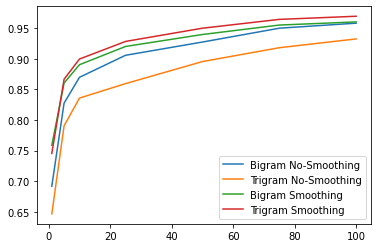

In [41]:
# importing package
import matplotlib.pyplot as plt
  
# create data
x = [1,5,10,25,50, 75, 100]
y1 = experiment_1_results
y2 = experiment_2_results
y3 = experiment_3_results
y4 = experiment_4_results
# plot lines
plt.plot(x, y1, label = "Bigram No-Smoothing")
plt.plot(x, y2, label = "Trigram No-Smoothing")
plt.plot(x, y3, label = "Bigram Smoothing")
plt.plot(x, y4, label = "Trigram Smoothing")

plt.legend()
plt.show()